In [1]:
#Dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
import time

from envs import OfflineEnv
from recommender import DRRAgent

import os

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

#  Check Data

In [2]:
#Loading datasets
ratings_list = pd.read_csv(r"sorted_ratings.csv")
users_list = pd.read_csv(r"dataset_csv\users.csv")
movies_list = pd.read_csv(r"dataset_csv\movies.csv")
# ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.uint32)
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings_df = ratings_df.astype({
    'UserID': np.uint32,
    'MovieID': np.uint32,
    'Rating': np.uint8,
    'Timestamp': np.uint32}) 
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [3]:
# moive id to movie title
movies_id_to_movies = {movie[0]: movie[1:] for movie in movies_list}

In [4]:
# number of movies
len(movies_list)

3883

In [5]:
# check the ratings
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
0,1,3186,4,978300019
1,1,1270,5,978300055
2,1,1721,4,978300055
3,1,1022,5,978300055
4,1,2340,3,978300103


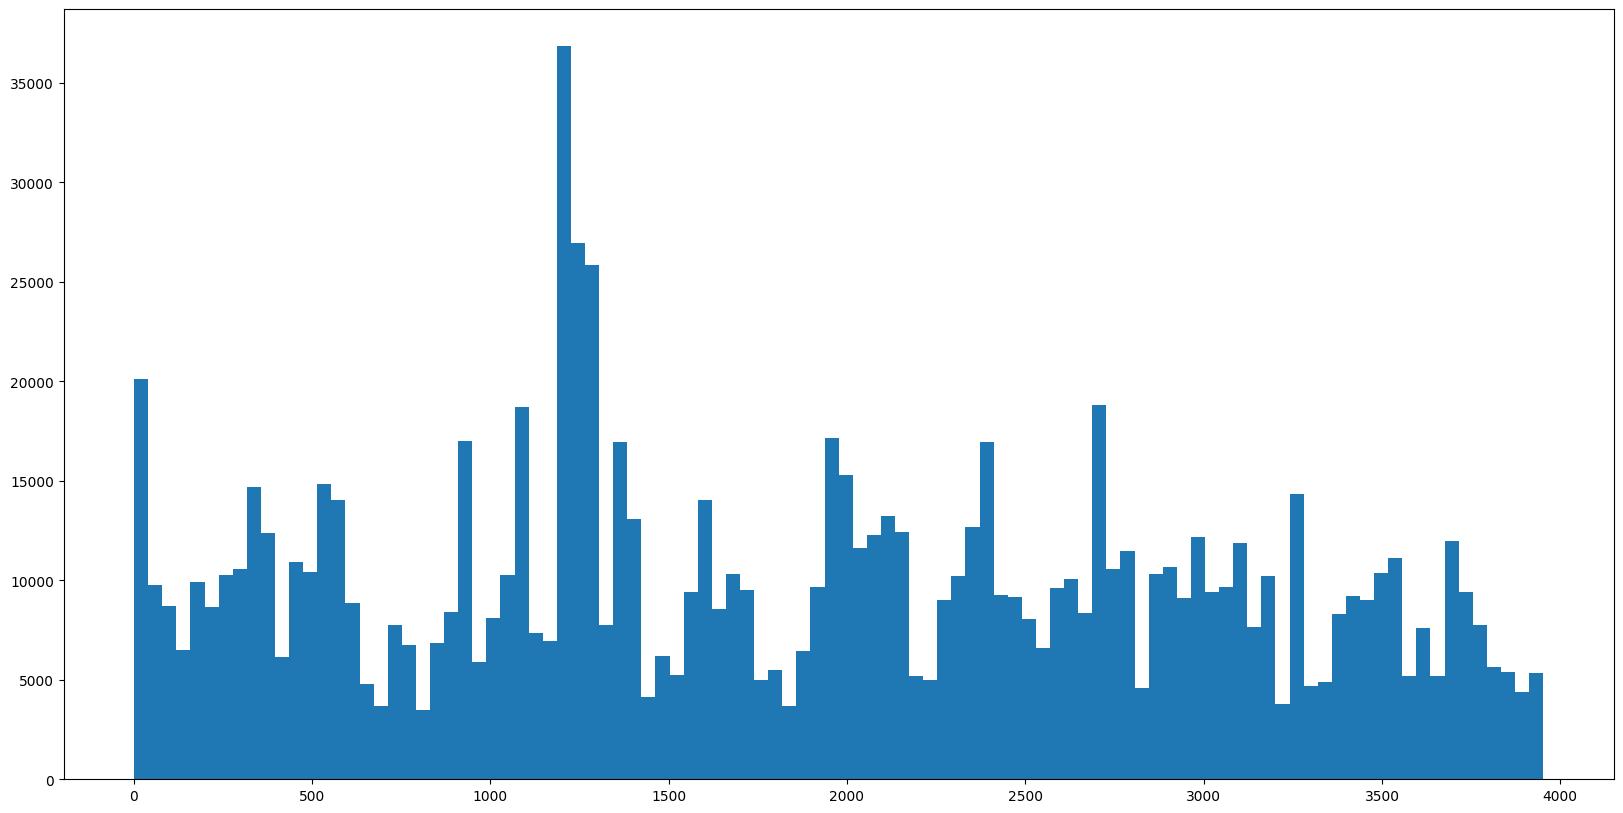

In [6]:
# check the distribution of movies choosen by user
plt.figure(figsize=(20,10))
plt.hist(ratings_df["MovieID"], bins=100)
plt.show()

In [7]:
# check null
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [8]:
# check the maximum value of UserID
print(len(set(ratings_df["UserID"])) == max([int(i) for i in set(ratings_df["UserID"])]))
print(max([int(i) for i in set(ratings_df["UserID"])]))

True
6040


In [9]:
# make suer the ratings are integer
ratings_df = ratings_df.applymap(int)

C:\Users\garvi\AppData\Local\Temp\ipykernel_15864\3532176190.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ratings_df = ratings_df.applymap(int)


In [ ]:
# make the user dictionary which have a value as movies list the user watched
users_dict = {user : [] for user in set(ratings_df["UserID"])}
print(users_dict[100])

[]


In [11]:
# order the dataset by time
ratings_df = ratings_df.sort_values(by='Timestamp', ascending=True)
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp
999868,6040,858,4,956703932
999869,6040,593,5,956703954
999870,6040,2384,4,956703954
999872,6040,2019,5,956703977
999871,6040,1961,4,956703977


In [12]:
# add (movie, rating) pair to the user dictionary
## add movie rated >= 4 only
ratings_df_gen = ratings_df.iterrows()
users_dict_for_history_len = {user : [] for user in set(ratings_df["UserID"])}
for data in ratings_df_gen:
    users_dict[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))
    if data[1]['Rating'] >= 4:
        users_dict_for_history_len[data[1]['UserID']].append((data[1]['MovieID'], data[1]['Rating']))

In [13]:
len(users_dict_for_history_len[1])

45

In [14]:
# the length of history for each user
users_history_lens = [len(users_dict_for_history_len[u]) for u in set(ratings_df["UserID"])]

In [15]:
# check the length of above list
print(len(users_history_lens))
print("---------------------")
users_history_lens

6040
---------------------


[45,
 73,
 37,
 18,
 82,
 50,
 26,
 85,
 69,
 305,
 68,
 14,
 40,
 13,
 99,
 13,
 167,
 194,
 143,
 19,
 6,
 119,
 129,
 110,
 52,
 102,
 54,
 70,
 52,
 22,
 68,
 28,
 200,
 113,
 115,
 303,
 36,
 56,
 34,
 50,
 14,
 143,
 20,
 120,
 91,
 33,
 17,
 156,
 65,
 13,
 26,
 46,
 536,
 33,
 18,
 50,
 31,
 324,
 109,
 34,
 9,
 263,
 50,
 23,
 108,
 16,
 56,
 50,
 54,
 34,
 19,
 30,
 117,
 30,
 134,
 73,
 12,
 82,
 16,
 33,
 74,
 88,
 56,
 22,
 15,
 42,
 27,
 55,
 13,
 104,
 42,
 142,
 84,
 14,
 54,
 49,
 145,
 12,
 51,
 20,
 98,
 59,
 86,
 21,
 50,
 36,
 75,
 17,
 71,
 34,
 59,
 45,
 39,
 66,
 22,
 56,
 210,
 135,
 51,
 34,
 63,
 25,
 286,
 20,
 56,
 38,
 112,
 18,
 124,
 114,
 168,
 63,
 125,
 55,
 40,
 171,
 117,
 59,
 157,
 36,
 15,
 23,
 36,
 17,
 15,
 280,
 101,
 391,
 429,
 188,
 282,
 20,
 19,
 15,
 39,
 130,
 262,
 17,
 23,
 9,
 273,
 81,
 58,
 24,
 83,
 227,
 18,
 18,
 336,
 62,
 19,
 12,
 393,
 56,
 232,
 45,
 33,
 79,
 28,
 35,
 182,
 55,
 77,
 60,
 27,
 102,
 350,
 28,
 22,
 86,
 

In [16]:
# check the user dictionary
len(users_dict[1])

53

In [17]:
import pickle

with open("data/users_dict.pkl", "wb") as f:
    pickle.dump(users_dict, f)

with open("data/users_history_lens.pkl", "wb") as f:
    pickle.dump(users_history_lens, f)

In [18]:
# save each data as npy to save time for future evaluation
np.save("./data/user_dict.npy", users_dict)
np.save("./data/users_histroy_len.npy", users_history_lens)

In [1]:
#Dependencies
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
import matplotlib.pyplot as plt
import time

from envs import OfflineEnv
from recommender import DRRAgent

import os


ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, 'ml-1m/')
STATE_SIZE = 10

#Loading datasets
ratings_list = pd.read_csv(r"sorted_ratings.csv")
users_list = pd.read_csv(r"dataset_csv\users.csv")
movies_list = pd.read_csv(r"dataset_csv\movies.csv")
# ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'], dtype = np.uint32)
ratings_df = pd.DataFrame(ratings_list, columns = ['UserID', 'MovieID', 'Rating', 'Timestamp'])
ratings_df = ratings_df.astype({
    'UserID': np.uint32,
    'MovieID': np.uint32,
    'Rating': np.uint8,
    'Timestamp': np.uint32}) 
movies_df = pd.DataFrame(movies_list, columns = ['MovieID', 'Title', 'Genres'])
movies_df['MovieID'] = movies_df['MovieID'].apply(pd.to_numeric)

In [2]:
# get the number of users and items
users_num = max(ratings_df["UserID"])+1
items_num = max(ratings_df["MovieID"])+1

In [3]:
# check the following variables
print(users_num, items_num)

6041 3953


In [4]:
import pickle

with open("data/users_dict.pkl", "rb") as f:
    users_dict = pickle.load(f)

with open("data/users_history_lens.pkl", "rb") as f:
    users_history_lens = pickle.load(f)

### setting for training dataset

In [5]:
train_users_num = int(users_num * 0.8)
train_items_num = items_num
print(train_users_num, train_items_num)

4832 3953


In [6]:
train_users_dict = {k:users_dict[k] for k in range(1, train_users_num+1)}
train_users_history_lens = users_history_lens[:train_users_num]
print(len(train_users_dict),len(train_users_history_lens))

4832 4832


### setting for evaluation dataset

In [7]:
eval_users_num = int(users_num * 0.2)
eval_items_num = items_num
print(eval_users_num, eval_items_num)

1208 3953


In [8]:
eval_users_dict = {k:users_dict[k] for k in range(users_num-eval_users_num, users_num)}
eval_users_history_lens = users_history_lens[-eval_users_num:]
print(len(eval_users_dict),len(eval_users_history_lens))

1208 1208


In [9]:
# Load movie info
movies_df = pd.read_csv("dataset_csv/movies.csv")
movies_id_to_movies = {row[0]: row[1:] for row in movies_df.values}



### the variables are ready
- users_dict
- users_history_len
- movies_id_to_movies
- users_num
- items_num

# Evalutation

In [10]:
def evaluate(recommender, env, check_movies = False, top_k=False):

    # episodic reward
    episode_reward = 0
    steps = 0
    mean_precision = 0
    mean_ndcg = 0
    # Environment
    user_id, items_ids, done = env.reset()
    if check_movies:
        print(f'user_id : {user_id}, rated_items_length:{len(env.user_items)}')
        print('history items : \n', np.array(env.get_items_names(items_ids)))

    while not done:

        # Observe current state & Find action
        ## Embedding
        user_eb = recommender.embedding_network.get_layer('user_embedding')(np.array(user_id))
        items_eb = recommender.embedding_network.get_layer('movie_embedding')(np.array(items_ids))
        ## SRM state
        state = recommender.srm_ave([np.expand_dims(user_eb, axis=0), np.expand_dims(items_eb, axis=0)])
        ## Action(ranking score)
        action = recommender.actor.network(state)
        ## Item 
        recommended_item = recommender.recommend_item(action, env.recommended_items, top_k=top_k)
        if check_movies:
            print(f'recommended items ids : {recommended_item}')
            print(f'recommened items : \n {np.array(env.get_items_names(recommended_item), dtype=object)}')
        # Calculate reward & observe new state (in env)
        ## Step
        next_items_ids, reward, done, _ = env.step(recommended_item, top_k=top_k)
        if top_k:
            correct_list = [1 if r > 0 else 0 for r in reward]
            # ndcg
            dcg, idcg = calculate_ndcg(correct_list, [1 for _ in range(len(reward))])
            mean_ndcg += dcg/idcg
            
            #precision
            correct_num = top_k-correct_list.count(0)
            mean_precision += correct_num/top_k
            
        reward = np.sum(reward)
        items_ids = next_items_ids
        episode_reward += reward
        steps += 1
        
        if check_movies:
            print(f'precision : {correct_num/top_k}, dcg : {dcg:0.3f}, idcg : {idcg:0.3f}, ndcg : {dcg/idcg:0.3f}, reward : {reward}')
            print()
        break
    
    if check_movies:
        print(f'precision : {mean_precision/steps}, ngcg : {mean_ndcg/steps}, episode_reward : {episode_reward}')
        print()
    
    return mean_precision/steps, mean_ndcg/steps

def calculate_ndcg(rel, irel):
    dcg = 0
    idcg = 0
    rel = [1 if r>0 else 0 for r in rel]
    for i, (r, ir) in enumerate(zip(rel, irel)):
        dcg += (r)/np.log2(i+2)
        idcg += (ir)/np.log2(i+2)
    return dcg, idcg

In [11]:
# get the saved model dir

saved_actor = "save_model/actor_model.weights.h5"
saved_critic = "save_model/critic_model.weights.h5"
# saved_actor = './save_model/trail-2022-12-13-04/actor_10_fixed.h5'
# saved_critic = './save_model/trail-2022-12-13-04/critic_10_fixed.h5'

In [12]:
tf.keras.backend.set_floatx('float64')

In [13]:
TOP_K = 10 # chose any k value as you want

sum_precision = 0
sum_ndcg = 0

end_evaluation = 10

for i, user_id in enumerate(eval_users_dict.keys()):
    env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=5501)
    recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
    recommender.actor.build_networks()
    recommender.critic.build_networks()
    recommender.load_model(saved_actor, saved_critic)
    precision, ndcg = evaluate(recommender, env, check_movies=True, top_k=TOP_K) # if check movies is true, you can check the recommended movies
    sum_precision += precision
    sum_ndcg += ndcg
    
    if i > end_evaluation:
        break
    
print(f'precision@{TOP_K} : {sum_precision/len(eval_users_dict)}, ndcg@{TOP_K} : {sum_ndcg/len(eval_users_dict)}')

c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\garvi\anaconda3\envs\DRR\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


user_id : 5501, rated_items_length:561
history items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
recommended items ids : [3000 3745 1081 1286 2747 3334  593 2746 2378 3708]
recommened items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
precision : 0.0, dcg : 0.000, idcg : 4.544, ndcg : 0.000, reward : -5.0

precision : 0.0, ngcg : 0.0, episode_reward : -5.0

user_id : 5501, rated_items_length:561
history items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
recommended items ids : [3000 3745 1081 1286 2747 3334  593 2746 2378 3708]
recommened items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['

In [14]:
TOP_K = 10 # chose any k value as you want

sum_precision = 0
sum_ndcg = 0

end_evaluation = 10

for i, user_id in enumerate(eval_users_dict.keys()):
    env = OfflineEnv(eval_users_dict, users_history_lens, movies_id_to_movies, STATE_SIZE, fix_user_id=user_id)
    recommender = DRRAgent(env, users_num, items_num, STATE_SIZE)
    recommender.actor.build_networks()
    recommender.critic.build_networks()
    recommender.load_model(saved_actor, saved_critic)
    precision, ndcg = evaluate(recommender, env, check_movies=True, top_k=TOP_K) # if check movies is true, you can check the recommended movies
    sum_precision += precision
    sum_ndcg += ndcg
    
    if i > end_evaluation:
        break
    
print(f'precision@{TOP_K} : {sum_precision/len(eval_users_dict)}, ndcg@{TOP_K} : {sum_ndcg/len(eval_users_dict)}')

user_id : 4833, rated_items_length:81
history items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
recommended items ids : [1046 1192 2746 2761 1284  778  661 3000 2747   50]
recommened items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
precision : 0.0, dcg : 0.000, idcg : 4.544, ndcg : 0.000, reward : -5.0

precision : 0.0, ngcg : 0.0, episode_reward : -5.0

user_id : 4834, rated_items_length:280
history items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']
 ['Not in list']]
recommended items ids : [2378   50 1192 2143 3000 2747 1286  661 2408 3708]
recommened items : 
 [['Not in list']
 ['Not in list']
 ['Not in list']
 ['N